In [1]:
!pip install -U openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 11.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.2 MB/s eta 0:00:0000:0100:01
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803404 sha256=4a7d76c7127536e0d8277779cd403657

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import librosa
import whisper
from tqdm.notebook import tqdm
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import Dataset
import types
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, confusion_matrix, auc

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


2025-06-23 19:29:31.465071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750706971.675475      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750706971.740460      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [3]:
# We'll use ASVspoof 2019 Logical Access dataset
# This cell assumes you've uploaded the dataset to Kaggle or are using the Kaggle dataset

DATA_PATH = "/kaggle/input/asvpoof-2019-dataset"

# Function to create a dataframe from ASVspoof protocol files
def create_dataframe(protocol_file, audio_dir):
    df_list = []
    
    with open(protocol_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                file_name = parts[1]
                label = 'real' if parts[-1] == 'bonafide' else 'fake'
                
                df_list.append({
                    'file_path': os.path.join(audio_dir, file_name + '.flac'),
                    'file_name': file_name,
                    'label': label,
                    'attack_type': parts[-1] if label == 'fake' else 'bonafide'
                })
    
    return pd.DataFrame(df_list)


In [4]:
train_df = create_dataframe(os.path.join(DATA_PATH, 'LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'), 
                           os.path.join(DATA_PATH, 'LA/LA/ASVspoof2019_LA_train/flac/'))

dev_df = create_dataframe(os.path.join(DATA_PATH, 'LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'), 
                         os.path.join(DATA_PATH, 'LA/LA/ASVspoof2019_LA_dev/flac/'))

# Use only a subset of the data to make it more manageable for Kaggle
# Taking 2000 samples from train and 500 from dev
train_df = train_df.sample(n=min(2000, len(train_df)), random_state=42)
dev_df = dev_df.sample(n=min(500, len(dev_df)), random_state=42)

# Display dataset statistics
print(f"Training set size: {len(train_df)}")
print(f"Dev set size: {len(dev_df)}")
print(f"Label distribution in training set:")
print(train_df['label'].value_counts())
print(f"Attack types in training set:")
print(train_df['attack_type'].value_counts())

missing_files = [f for f in train_df['file_path'] if not os.path.exists(f)]
if missing_files:
    print(f"Warning: {len(missing_files)} files not found!")


Training set size: 2000
Dev set size: 500
Label distribution in training set:
label
fake    1799
real     201
Name: count, dtype: int64
Attack types in training set:
attack_type
spoof       1799
bonafide     201
Name: count, dtype: int64


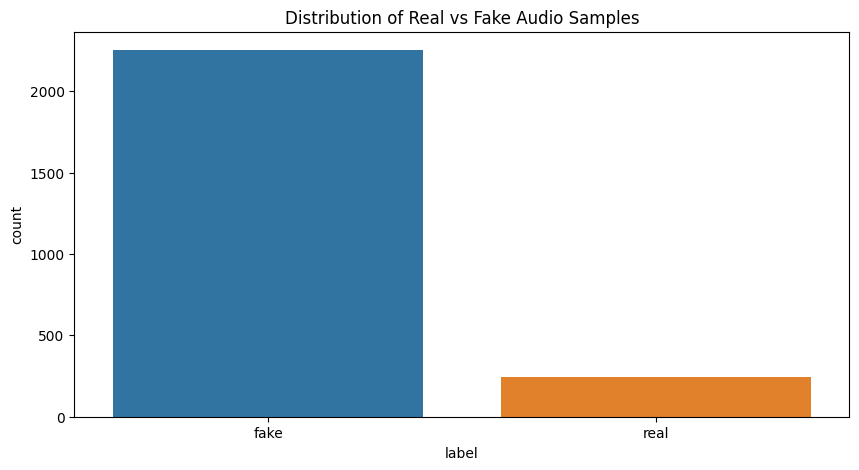

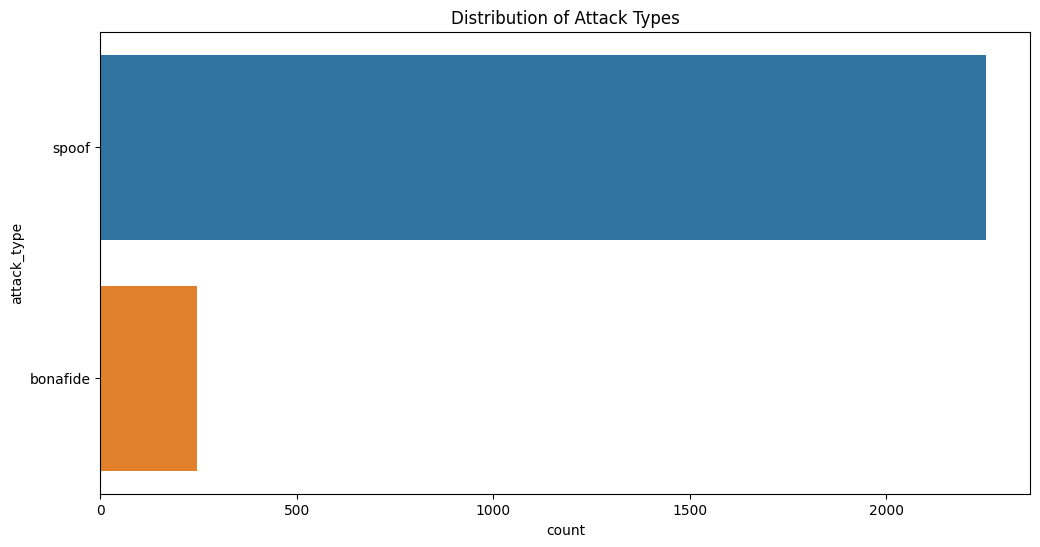

In [5]:
# Plot label distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=pd.concat([train_df, dev_df]))
plt.title('Distribution of Real vs Fake Audio Samples')
plt.savefig('label_distribution.png')
plt.show()

# Plot attack type distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='attack_type', data=pd.concat([train_df, dev_df]))
plt.title('Distribution of Attack Types')
plt.savefig('attack_distribution.png')
plt.show()



In [6]:
# Function to extract audio duration
def get_audio_duration(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None, duration=10)
        return librosa.get_duration(y=y, sr=sr)
    except:
        return np.nan

sample_files = train_df['file_path'].sample(n=min(100, len(train_df)), random_state=42)
durations = [get_audio_duration(f) for f in tqdm(sample_files)]


  0%|          | 0/100 [00:00<?, ?it/s]

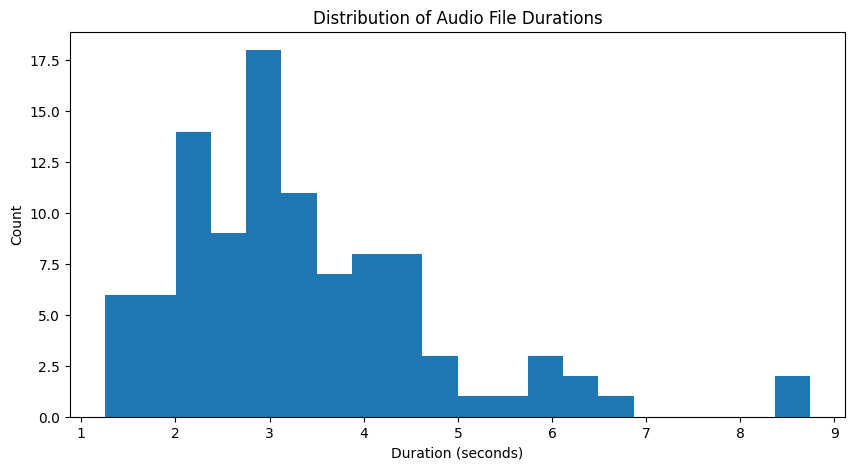

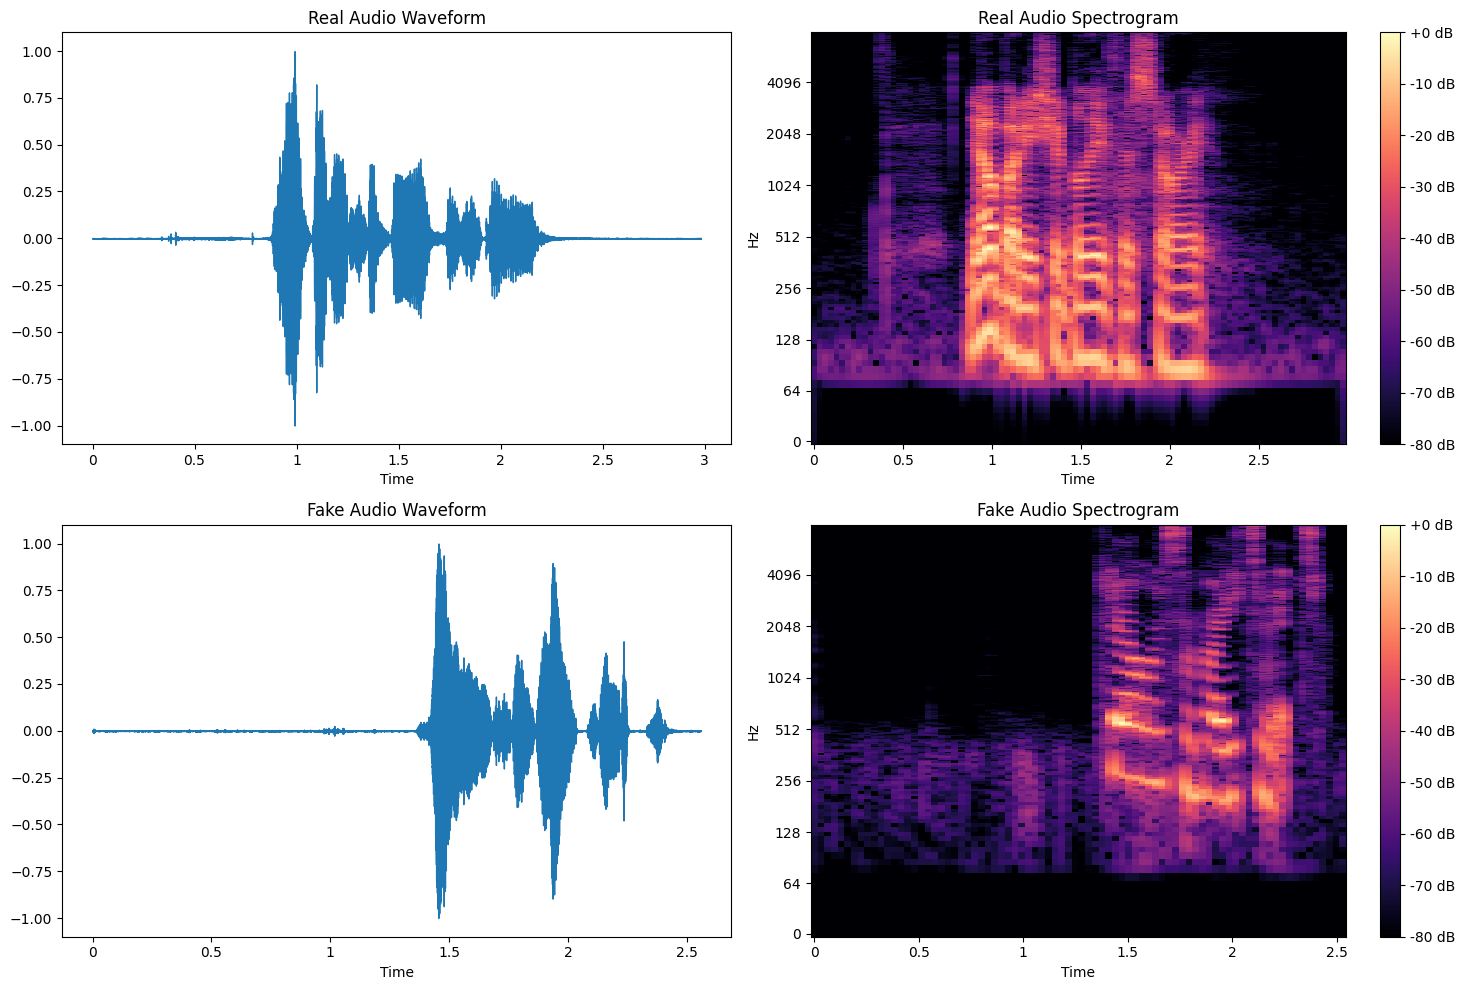

In [7]:
# Plot duration distribution
plt.figure(figsize=(10, 5))
plt.hist(durations, bins=20)
plt.title('Distribution of Audio File Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.savefig('duration_distribution.png')
plt.show()

# Plot a few spectrograms
plt.figure(figsize=(15, 10))
for i, label in enumerate(['real', 'fake']):
    sample_file = train_df[train_df['label'] == label]['file_path'].iloc[0]
    y, sr = librosa.load(sample_file, sr=None)
    
    plt.subplot(2, 2, i*2+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'{label.capitalize()} Audio Waveform')
    
    plt.subplot(2, 2, i*2+2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{label.capitalize()} Audio Spectrogram')

plt.tight_layout()
plt.savefig('audio_visualization.png')
plt.show()


In [8]:
# Load Whisper model (small version for efficiency on Kaggle)
print("Loading Whisper model...")
asr_model = whisper.load_model("small")

# Function to transcribe audio files
def transcribe_audio(file_path):
    try:
        result = asr_model.transcribe(file_path, fp16=False)
        return result["text"]
    except Exception as e:
        print(f"Error transcribing {file_path}: {e}")
        return ""

print("Transcribing audio files...")

processed_train = train_df.copy()
processed_dev = dev_df.copy()

for df in [processed_train, processed_dev]:
    transcriptions = []
    for file_path in tqdm(df['file_path']):
        transcriptions.append(transcribe_audio(file_path))
    df['transcript'] = transcriptions

processed_train.to_csv('processed_train.csv', index=False)
processed_dev.to_csv('processed_dev.csv', index=False)

print("\nSample transcriptions:")
for label in ['real', 'fake']:
    samples = processed_train[processed_train['label'] == label].head(2)
    for _, row in samples.iterrows():
        print(f"{label.upper()} sample: {row['transcript']}")
        

Loading Whisper model...


100%|███████████████████████████████████████| 461M/461M [00:37<00:00, 12.9MiB/s]


Transcribing audio files...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


Sample transcriptions:
REAL sample:  Nobody should believe this story.
REAL sample:  Is there a waiting list?
FAKE sample:  Careless about it.
FAKE sample:  Strathclyde police said they were treating the shooting as attempted murder.


In [9]:
# Function to extract acoustic features
def extract_acoustic_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        
        # Extract MFCCs - capture vocal tract configuration
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_means = np.mean(mfccs, axis=1)
        mfcc_vars = np.var(mfccs, axis=1)
        
        # Extract spectral contrast - difference between peaks and valleys
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        contrast_means = np.mean(contrast, axis=1)
        
        # Extract pitch information
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch_means = np.mean(pitches, axis=1)
        
        # Extract zero crossing rate - measure of noisiness
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        
        # Combine features
        features = np.concatenate([
            mfcc_means, mfcc_vars, contrast_means, 
            [np.mean(pitch_means)], [zcr_mean]
        ])
        
        return features
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return np.zeros(40) 

print("Extracting acoustic features...")
acoustic_features_train = []
for file_path in tqdm(processed_train['file_path']):
    acoustic_features_train.append(extract_acoustic_features(file_path))

acoustic_features_dev = []
for file_path in tqdm(processed_dev['file_path']):
    acoustic_features_dev.append(extract_acoustic_features(file_path))

acoustic_features_train = np.array(acoustic_features_train)
acoustic_features_dev = np.array(acoustic_features_dev)

mean = np.mean(acoustic_features_train, axis=0)
std = np.std(acoustic_features_train, axis=0)
std[std == 0] = 1

acoustic_features_train = (acoustic_features_train - mean) / std
acoustic_features_dev = (acoustic_features_dev - mean) / std


Extracting acoustic features...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

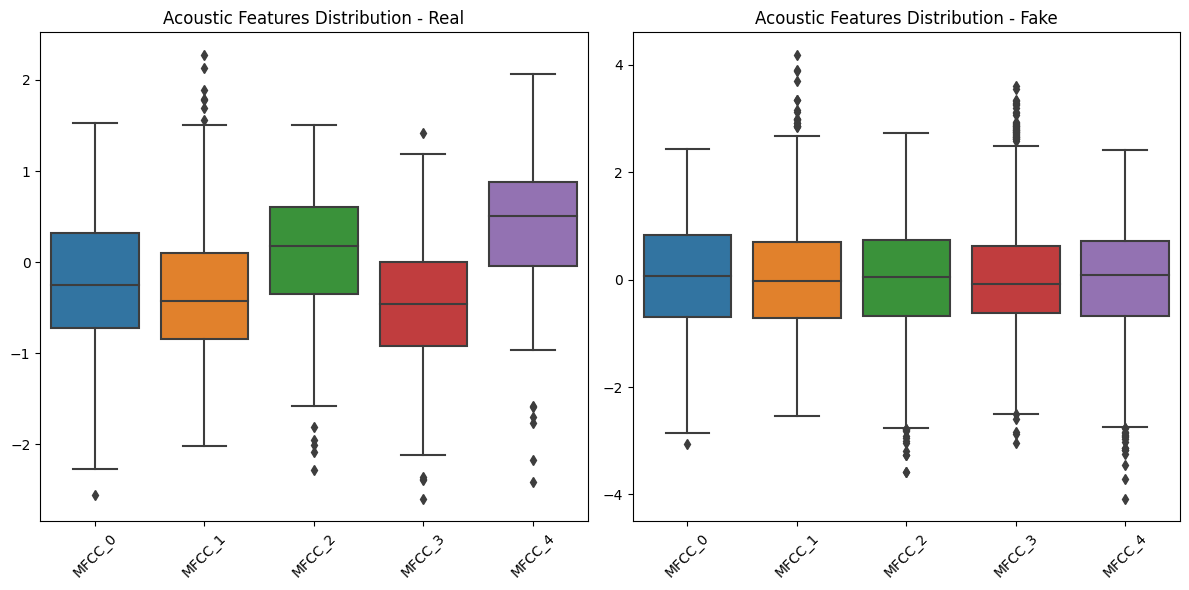

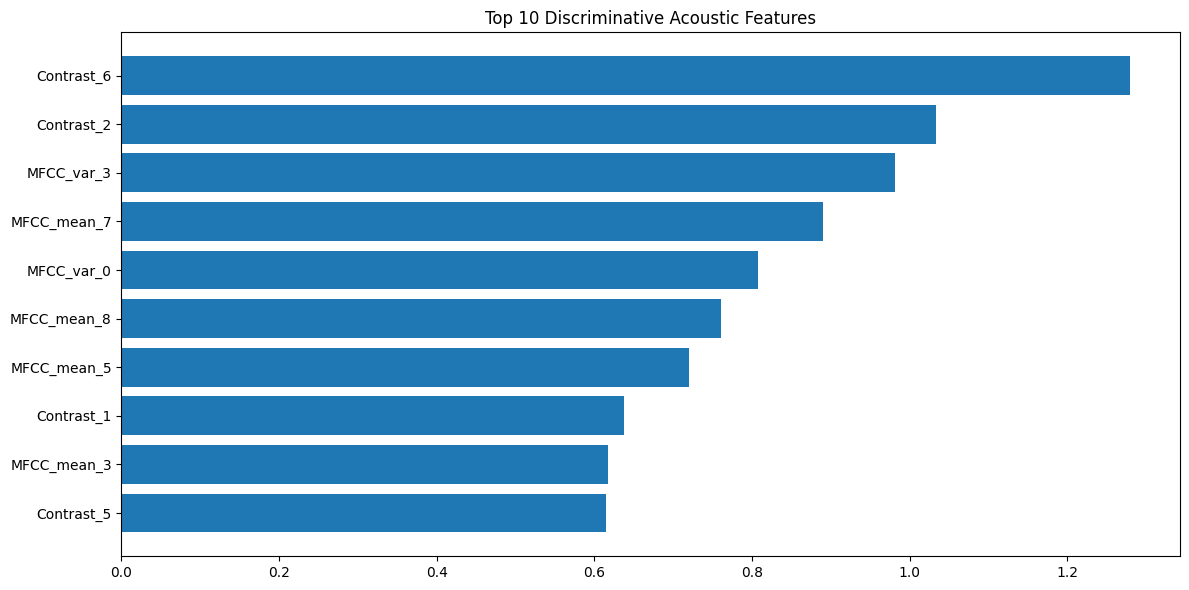

In [10]:
# Plot acoustic feature distributions
plt.figure(figsize=(12, 6))
for i, label in enumerate(['real', 'fake']):
    indices = processed_train['label'] == label
    feature_subset = acoustic_features_train[indices, :5]
    
    plt.subplot(1, 2, i+1)
    sns.boxplot(data=pd.DataFrame(feature_subset, columns=[f'MFCC_{i}' for i in range(5)]))
    plt.title(f'Acoustic Features Distribution - {label.capitalize()}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('acoustic_features.png')
plt.show()

# Feature importance
plt.figure(figsize=(12, 6))
feature_names = [f'MFCC_mean_{i}' for i in range(13)] + \
                [f'MFCC_var_{i}' for i in range(13)] + \
                [f'Contrast_{i}' for i in range(7)] + \
                ['Pitch_mean', 'ZCR_mean']

real_indices = processed_train['label'] == 'real'
fake_indices = processed_train['label'] == 'fake'

t_stats = []
for i in range(acoustic_features_train.shape[1]):
    real_feat = acoustic_features_train[real_indices, i]
    fake_feat = acoustic_features_train[fake_indices, i]
    
    mean_diff = np.abs(np.mean(real_feat) - np.mean(fake_feat))
    pooled_std = np.sqrt((np.var(real_feat) + np.var(fake_feat)) / 2)
    t_stat = mean_diff / (pooled_std + 1e-10)
    t_stats.append(t_stat)

top_indices = np.argsort(t_stats)[-10:]
plt.barh(np.array(feature_names)[top_indices], np.array(t_stats)[top_indices])
plt.title('Top 10 Discriminative Acoustic Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to prepare dataset with transcripts and acoustic features
def prepare_dataset(df, acoustic_features):
    acoustic_features_list = acoustic_features.tolist()
    
    dataset_dict = {
        'transcript': df['transcript'].tolist(),
        'acoustic_features': acoustic_features_list,
        'label': [1 if label == 'fake' else 0 for label in df['label']]
    }
    
    dataset = Dataset.from_dict(dataset_dict)
    
    # Tokenize transcripts
    def tokenize_function(examples):
        return tokenizer(examples['transcript'], padding='max_length', truncation=True, max_length=128)
    
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    
    tokenized_dataset = tokenized_dataset.remove_columns(['transcript'])
    
    tokenized_dataset.set_format(
        type='torch', 
        columns=['input_ids', 'attention_mask', 'label'],
        output_all_columns=True # To keep acoustic features accessible
    )
    
    return tokenized_dataset


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
train_dataset = prepare_dataset(processed_train, acoustic_features_train)
dev_dataset = prepare_dataset(processed_dev, acoustic_features_dev)

print(f"Training dataset: {train_dataset}")
print(f"Dev dataset: {dev_dataset}")


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Training dataset: Dataset({
    features: ['acoustic_features', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})
Dev dataset: Dataset({
    features: ['acoustic_features', 'label', 'input_ids', 'attention_mask'],
    num_rows: 500
})


In [13]:
# Custom DistilBERT model with acoustic features
class DistilBertWithAcousticFeatures(torch.nn.Module):
    def __init__(self, num_acoustic_features):
        super().__init__()
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased', 
            num_labels=2,
            return_dict=True
        )
        
        # Freeze some layers to prevent overfitting except the last transformer block and classifier
        for param in self.distilbert.distilbert.parameters():
            param.requires_grad = False
        
        for param in self.distilbert.distilbert.transformer.layer[-1].parameters():
            param.requires_grad = True
        
        for param in self.distilbert.classifier.parameters():
            param.requires_grad = True
        
        # Additional layers for acoustic features
        self.acoustic_fc = torch.nn.Linear(num_acoustic_features, 32)
        self.acoustic_bn = torch.nn.BatchNorm1d(32)
        
        # Replace the classifier with a new one that takes both text and acoustic features
        hidden_size = self.distilbert.classifier.in_features
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_size + 32, 256),
            torch.nn.LayerNorm(256),
            torch.nn.Dropout(0.1),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2)
        )
        
    def forward(self, input_ids, attention_mask, acoustic_features, labels=None):
        outputs = self.distilbert.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        sequence_output = outputs.last_hidden_state[:, 0]
        
        acoustic_output = self.acoustic_fc(acoustic_features)
        acoustic_output = self.acoustic_bn(acoustic_output)
        acoustic_output = torch.nn.functional.relu(acoustic_output)
        
        combined_output = torch.cat([sequence_output, acoustic_output], dim=1)
        
        logits = self.classifier(combined_output)
        
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}


In [14]:
num_acoustic_features = acoustic_features_train.shape[1]
model = DistilBertWithAcousticFeatures(num_acoustic_features)
model.to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertWithAcousticFeatures(
  (distilbert): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): DistilBertSdpaAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [15]:
train_labels = [item['label'].item() for item in train_dataset]
class_counts = np.bincount(train_labels)
print(f"Class distribution - Real: {class_counts[0]}, Fake: {class_counts[1]}")


Class distribution - Real: 201, Fake: 1799


In [16]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class weights: {class_weights}")


Class weights: tensor([4.9751, 0.5559], device='cuda:0')


In [17]:
# Modify the forward method to use weighted loss
def weighted_forward(self, input_ids, attention_mask, acoustic_features, labels=None):
    outputs = self.distilbert.distilbert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    
    sequence_output = outputs.last_hidden_state[:, 0]
    
    acoustic_output = self.acoustic_fc(acoustic_features)
    acoustic_output = self.acoustic_bn(acoustic_output)
    acoustic_output = torch.nn.functional.relu(acoustic_output)
    
    combined_output = torch.cat([sequence_output, acoustic_output], dim=1)
    
    logits = self.classifier(combined_output)
    
    loss = None
    if labels is not None:
        # Use weighted loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
    
    return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}


In [18]:
model.forward = types.MethodType(weighted_forward, model)

print(f"Model initialized with {num_acoustic_features} acoustic features and class weighting")


Model initialized with 35 acoustic features and class weighting


In [19]:
# Create a simple data collator for batching
class CustomDataCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        label = torch.stack([item['label'] for item in batch])
        
        acoustic_features = torch.tensor([item['acoustic_features'] for item in batch], dtype=torch.float32)
        
        return {
            'input_ids': input_ids, 
            'attention_mask': attention_mask,
            'acoustic_features': acoustic_features,
            'labels': label
        }


In [20]:
batch_size = 16

if 'train_labels' not in locals():
    train_labels = [item['label'].item() for item in train_dataset]

label_counts = np.bincount(train_labels)
weight_per_class = 1. / label_counts
sample_weights = [weight_per_class[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler,
    collate_fn=CustomDataCollator()
)

dev_loader = DataLoader(
    dev_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    collate_fn=CustomDataCollator()
)

print(f"Created balanced train loader with {len(train_loader)} batches")
print(f"Created dev loader with {len(dev_loader)} batches")


Created balanced train loader with 125 batches
Created dev loader with 32 batches


In [21]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=len(train_loader)*3)

# Training loop
num_epochs = 10
best_f1 = 0
best_model_state = None

history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_f1': [],
    'threshold': []
}

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    
    model.train()
    train_loss = 0
    
    print(f"Training...")
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        acoustic_features = batch['acoustic_features'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            acoustic_features=acoustic_features,
            labels=labels
        )
        
        loss = outputs['loss']
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")
    
    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg. training loss: {avg_train_loss:.4f}")
    
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    print(f"Evaluating...")
    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            acoustic_features = batch['acoustic_features'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                acoustic_features=acoustic_features,
                labels=labels
            )
            
            loss = outputs['loss']
            val_loss += loss.item()
            
            logits = outputs['logits']
            probs = torch.nn.functional.softmax(logits, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())
    
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    if len(thresholds) > 0:
        f1_scores = 2 * recall * precision / (recall + precision + 1e-8)
        best_threshold_idx = np.argmax(f1_scores[:-1])
        best_threshold = thresholds[best_threshold_idx]
        print(f"Optimal threshold: {best_threshold:.4f}")
    else:
        best_threshold = 0.5
        print("Using default threshold of 0.5")
    
    all_preds = [1 if prob >= best_threshold else 0 for prob in all_probs]
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    
    avg_val_loss = val_loss / len(dev_loader)
    
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(accuracy)
    history['val_f1'].append(f1)
    history['threshold'].append(best_threshold)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Results:")
    print(f"  Loss: {avg_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Threshold: {best_threshold:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_state = model.state_dict().copy()
        print(f"  New best model saved with F1 score: {best_f1:.4f}")

if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with F1 score: {best_f1:.4f}")

torch.save(model.state_dict(), "./deepfake_audio_detector.pt")
print("Model saved to ./deepfake_audio_detector.pt")


Starting epoch 1/10
Training...
  Batch 10/125 - Loss: 0.4387
  Batch 20/125 - Loss: 0.3957
  Batch 30/125 - Loss: 0.3941
  Batch 40/125 - Loss: 0.2289
  Batch 50/125 - Loss: 0.2821
  Batch 60/125 - Loss: 0.2126
  Batch 70/125 - Loss: 0.3172
  Batch 80/125 - Loss: 0.3414
  Batch 90/125 - Loss: 0.3099
  Batch 100/125 - Loss: 0.3566
  Batch 110/125 - Loss: 0.4009
  Batch 120/125 - Loss: 0.2083
Epoch 1/10 - Avg. training loss: 0.3170
Evaluating...
Optimal threshold: 0.0381
Epoch 1/10 - Validation Results:
  Loss: 1.0627
  Accuracy: 0.9200
  Precision: 0.9243
  Recall: 0.9934
  F1 Score: 0.9576
  Threshold: 0.0381
  New best model saved with F1 score: 0.9576
Starting epoch 2/10
Training...
  Batch 10/125 - Loss: 0.2418
  Batch 20/125 - Loss: 0.4920
  Batch 30/125 - Loss: 0.1288
  Batch 40/125 - Loss: 0.2131
  Batch 50/125 - Loss: 0.2437
  Batch 60/125 - Loss: 0.2298
  Batch 70/125 - Loss: 0.2756
  Batch 80/125 - Loss: 0.1946
  Batch 90/125 - Loss: 0.1569
  Batch 100/125 - Loss: 0.2367
  Ba

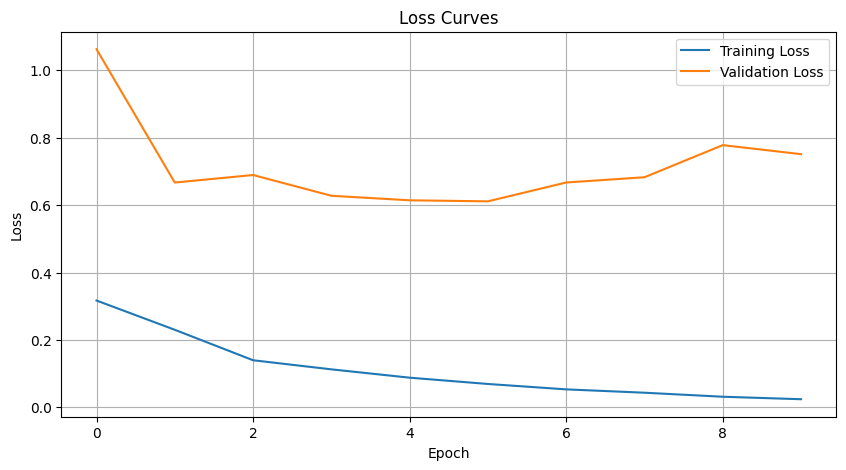

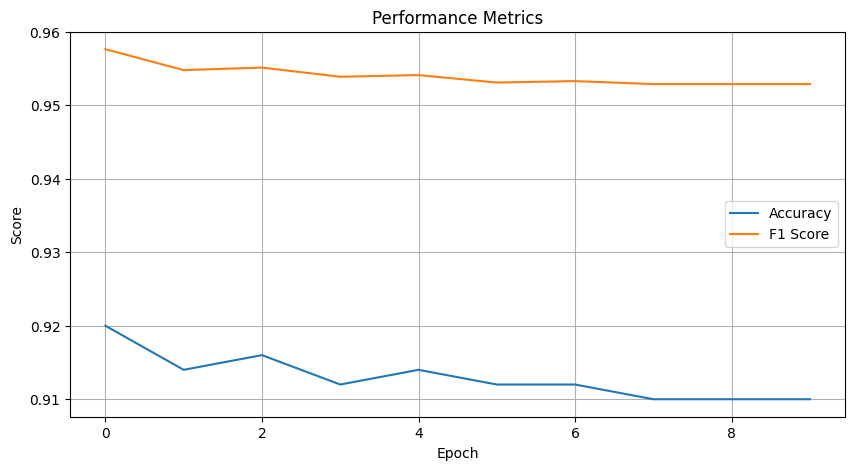

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['val_accuracy'], label='Accuracy')
plt.plot(history['val_f1'], label='F1 Score')
plt.title('Performance Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('performance_metrics.png')
plt.show()


Accuracy: 0.8580
Equal Error Rate (EER): 0.2444 at threshold 0.9024


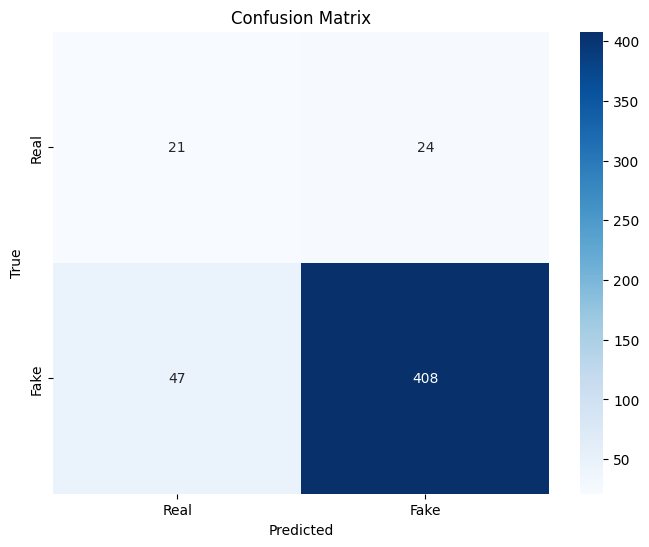

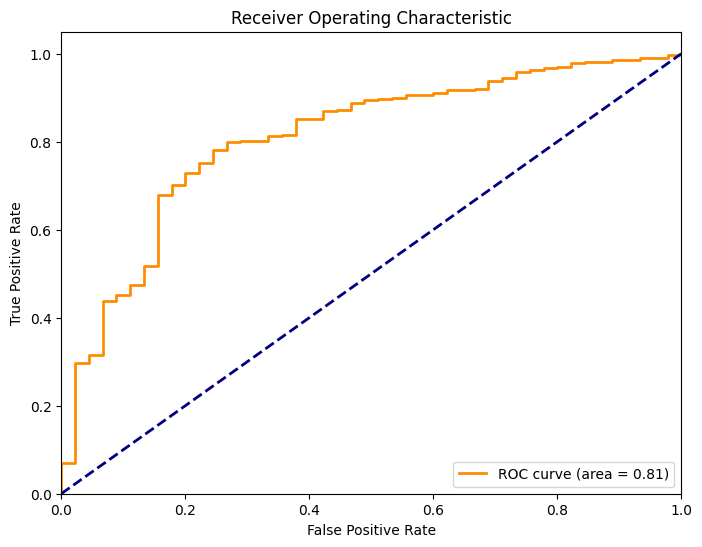

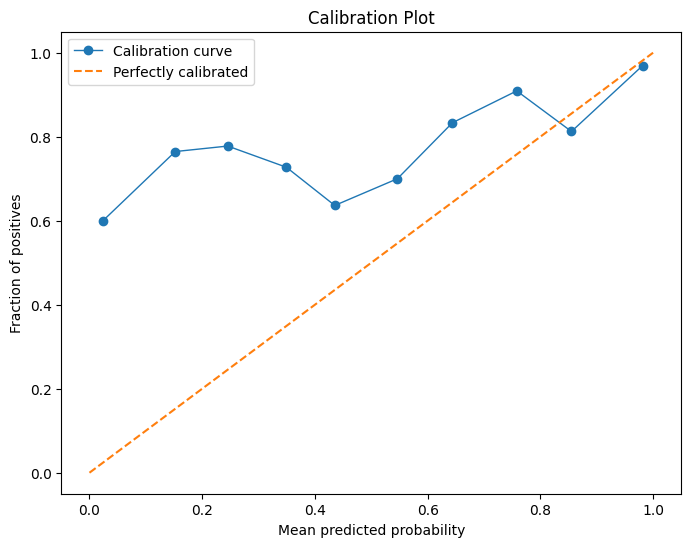

In [23]:
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in dev_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        acoustic_features = batch['acoustic_features'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            acoustic_features=acoustic_features
        )
        
        logits = outputs['logits']
        probs = torch.nn.functional.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

def calculate_eer(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    fnr = 1 - tpr
    
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    
    return eer, eer_threshold

eer, threshold = calculate_eer(all_labels, all_probs)
print(f"Equal Error Rate (EER): {eer:.4f} at threshold {threshold:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

# Model calibration
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 6))
prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend(loc='best')
plt.savefig('calibration_plot.png')
plt.show()



Testing file: LA_D_6341313.flac
True label: real
Prediction: fake with 99.41% confidence
Transcript:  We are delighted with this outcome.


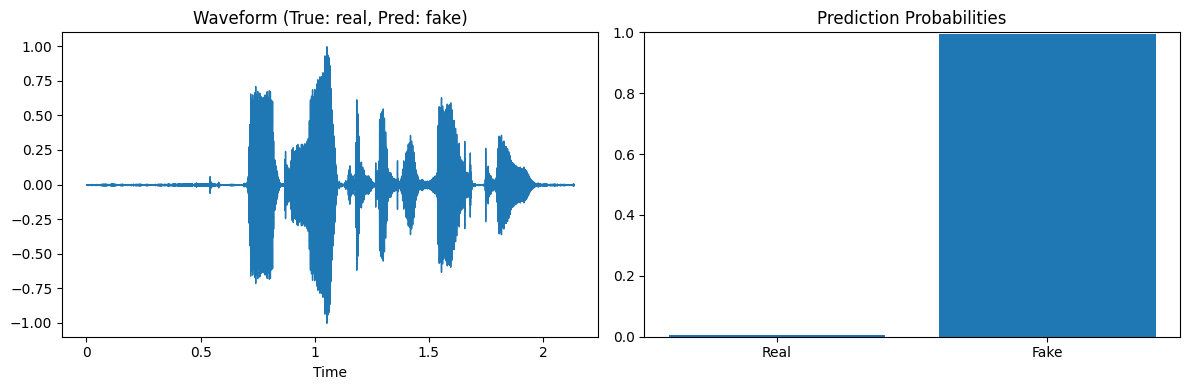


Testing file: LA_D_5467345.flac
True label: real
Prediction: fake with 88.33% confidence
Transcript:  Yma waith y cefnogi's cyng�lion o gyfree yno fod liquid adesafet Local


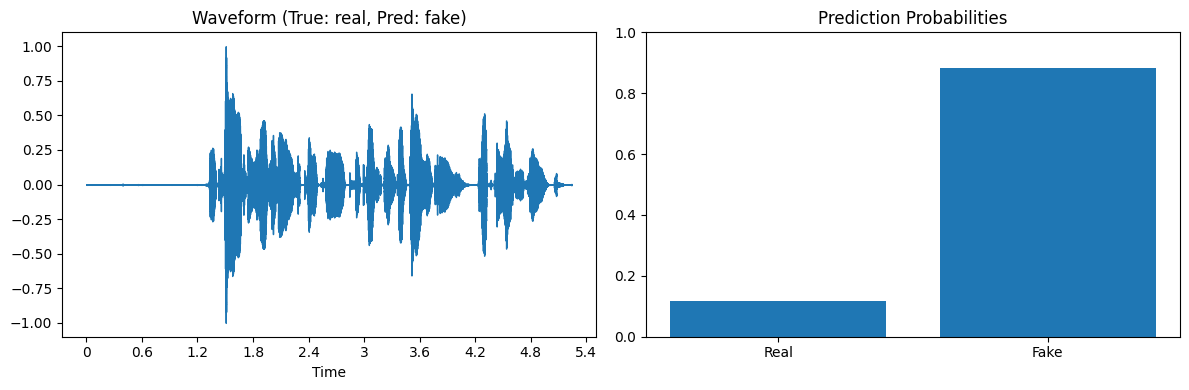


Testing file: LA_D_3164494.flac
True label: fake
Prediction: fake with 99.66% confidence
Transcript:  Now we have to take it onto the field.


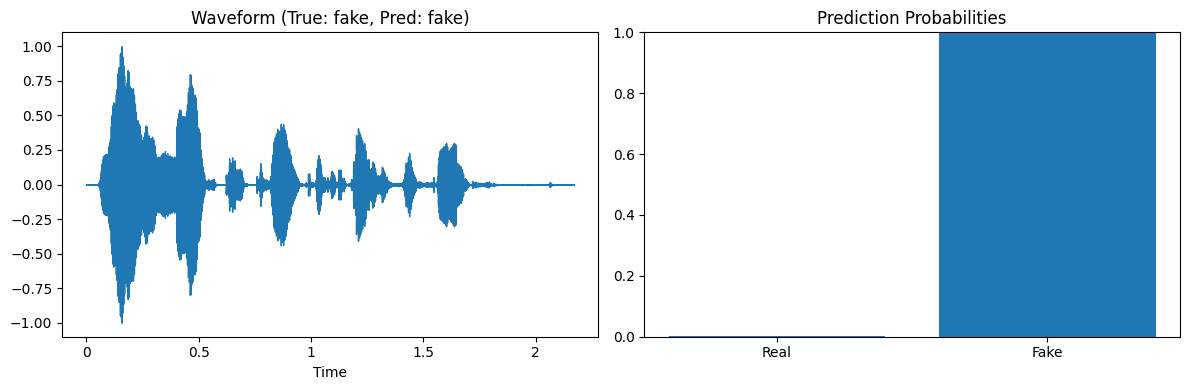


Testing file: LA_D_2557874.flac
True label: fake
Prediction: fake with 99.68% confidence
Transcript:  Transport to school has not been withdrawn.


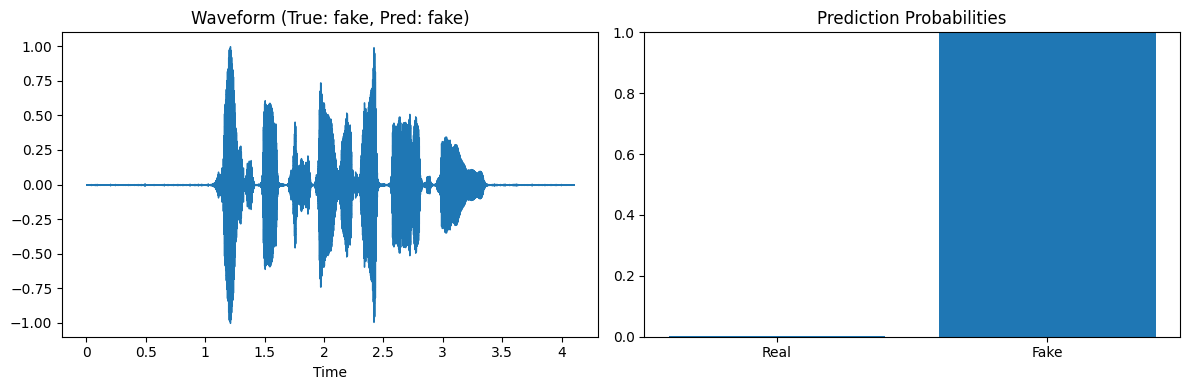

In [24]:
# Sample predictions on a few examples
def predict_sample(file_path):
    transcript = transcribe_audio(file_path)
    acoustic_feats = extract_acoustic_features(file_path)
    acoustic_feats = (acoustic_feats - mean) / std
    
    inputs = tokenizer(transcript, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    acoustic_feats = torch.tensor(acoustic_feats, dtype=torch.float32).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, 
                      attention_mask=attention_mask, 
                      acoustic_features=acoustic_feats)
    
    logits = outputs['logits']
    probs = torch.nn.functional.softmax(logits, dim=1)
    prediction = torch.argmax(probs, dim=1).item()
    
    return {
        'prediction': 'fake' if prediction == 1 else 'real',
        'confidence': probs[0][prediction].item(),
        'transcript': transcript,
        'probs': probs[0].cpu().numpy()
    }

# Few samples for prediction
sample_files = []
for label in ['real', 'fake']:
    examples = dev_df[dev_df['label'] == label].sample(min(2, len(dev_df[dev_df['label'] == label])))
    sample_files.extend(examples['file_path'].tolist())

# Test
for file_path in sample_files:
    true_label = dev_df[dev_df['file_path'] == file_path]['label'].values[0]
    
    print(f"\nTesting file: {os.path.basename(file_path)}")
    print(f"True label: {true_label}")
    
    result = predict_sample(file_path)
    
    print(f"Prediction: {result['prediction']} with {result['confidence']*100:.2f}% confidence")
    print(f"Transcript: {result['transcript']}")
    
    plt.figure(figsize=(12, 4))
    
    # Plot waveform
    y, sr = librosa.load(file_path, sr=None)
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform (True: {true_label}, Pred: {result['prediction']})")
    
    # Plot probabilities
    plt.subplot(1, 2, 2)
    plt.bar(['Real', 'Fake'], result['probs'])
    plt.ylim(0, 1)
    plt.title('Prediction Probabilities')
    
    plt.tight_layout()
    plt.savefig(f"sample_prediction_{os.path.basename(file_path)}.png")
    plt.show()
    